In [1]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

This non-commercial license of GraphLab Create for academic use is assigned to ref302@nyu.edu and will expire on October 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479678132.log


In [382]:
with open('focalbook.txt') as f:
    focalBookID = int(f.next())
    focalBookCollectionTag = f.next().rstrip()

focalBookInfo = bookTitle(focalBookID)
print 'Focal book: %d (%s), with %d ratings' %(focalBookID, focalBookInfo[0], focalBookInfo[1])
#exploreFromBook(focalBookID, ratingsFromBook, friendsFromBook, booksFromBook, 0.05)

Focal book: 6759 (Infinite Jest), with 51175 ratings


In [383]:
# setting up mongodb

client = MongoClient('mongodb://localhost:27017/')

db = client['goodreads_explore_multigraph']

friendsUnbiased = db['friends']
ratingsUnbiased = db['reviews']
booksUnbiased = db['books']

dbBiased = client['goodreads_explore_multigraph_biased_sampling']

friendsBiased = dbBiased['friends']
ratingsBiased = dbBiased['reviews']
booksBiased = dbBiased['books']

dbFromBook = client['goodreads_explore_from_book_' + focalBookCollectionTag]

friendsFromBook = dbFromBook['friends']
ratingsFromBook = dbFromBook['reviews']
booksFromBook = dbFromBook['books']

dbSnowball = client['goodreads_snowball']
friendsSnowball = dbSnowball['friends']
ratingsSnowball = dbSnowball['reviews']
booksSnowball = dbSnowball['books']

In [384]:
checkBiased = False
checkFromBook = True
checkSnowball = False

In [385]:
# checking what we've got

if checkBiased:
    friends = friendsBiased
    ratings = ratingsBiased
    books = booksBiased
elif checkFromBook:
    friends = friendsFromBook
    ratings = ratingsFromBook
    books = booksFromBook
elif checkSnowball:
    friends = friendsSnowball
    ratings = ratingsSnowball
    books = booksSnowball
else:
    friends = friendsUnbiased
    ratings = ratingsUnbiased
    books = booksUnbiased

print '%d users' % ratings.count()
print '%d books' % books.count()
print '%d users have scraped friend lists\n' % friends.count()

if ratings.count() > 0:
    t = books.find()
    countList = []

    for b in t:
        countList.append(len(b['ratings']))

    clS = pd.Series(countList)
        
    print '%.2f%% of books have >1 ratings' % float(100*(clS>1).mean())
    print '(%d books)\n' %(clS>1).sum()

    print '%.2f%% of books have >2 ratings' % float(100*(clS>2).mean())
    print '(%d books)\n' %(clS>2).sum()

    print '%.2f%% of books have >5 ratings' % float(100*(clS>5).mean())
    print '(%d books)\n' %(clS>5).sum()

    print '%.2f%% of books have >10 ratings' % float(100*(clS>10).mean())
    print '(%d books)\n' %(clS>10).sum()

    print 'Descriptive statistics for ratings:'
    print clS.describe()

926 users
104777 books
926 users have scraped friend lists

23.70% of books have >1 ratings
(24837 books)

12.53% of books have >2 ratings
(13131 books)

4.88% of books have >5 ratings
(5118 books)

2.30% of books have >10 ratings
(2406 books)

Descriptive statistics for ratings:
count    104777.000000
mean          2.127948
std           6.321685
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         369.000000
dtype: float64


In [305]:
nUserCounts = []
for i, row in enumerate(ratings.find()):
    nUserCounts.append(len(row['ratings']))
    
nBookCounts = []
bookIDlist = []
for i, row in enumerate(books.find()):
    nBookCounts.append(len(row['ratings']))
    bookIDlist.append(row['bookID'])

In [306]:
'''
for index in np.argsort(nBookCounts)[::-1][20:]:
    print (bookTitle(bookIDlist[index]),nBookCounts[index])
'''

'\nfor index in np.argsort(nBookCounts)[::-1][20:]:\n    print (bookTitle(bookIDlist[index]),nBookCounts[index])\n'

In [294]:
nUserCounts = pd.Series(nUserCounts)
print (nUserCounts < 10).mean()

nBookCounts = pd.Series(nBookCounts)
print (nBookCounts < 2).mean()

bookIDlist = pd.Series(bookIDlist)
booksToExclude = set(bookIDlist[nBookCounts < 10])
print (nBookCounts >= 10).sum()

0.0226781857451
0.762953701671
2714


In [221]:
nBookCounts[nBookCounts>=10].describe()

count    478.000000
mean      17.248954
std        8.746053
min       10.000000
25%       11.000000
50%       14.000000
75%       20.000000
max       86.000000
dtype: float64

In [222]:
nUserCounts.describe()

count      105.000000
mean       624.942857
std       1358.742234
min         16.000000
25%        121.000000
50%        253.000000
75%        627.000000
max      12547.000000
dtype: float64

In [56]:
targetRatings = books.find_one({'bookID': focalBookID})['ratings']
targetRatingDates = np.array([datetime.strptime(r[2], grDateFormat) for r in targetRatings.values()])
#strictCutoff = min(targetRatingDates)
#print strictCutoff.strftime(grDateFormat)
print len(targetRatingDates)
print sum(targetRatingDates > datetime.strptime('Jan 1, 2014', grDateFormat)) / float(len(targetRatingDates))
cutoffDate = datetime.strptime('Jan 1, 2014', grDateFormat)
todayDate = date.today()
today = datetime(todayDate.year, todayDate.month, todayDate.day)

291
0.250859106529


In [261]:
glRatingDict = makeRatingDictForGL(ratings, booksToExclude)
glRatings = gl.SFrame(glRatingDict)

In [324]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")

In [350]:
nTrainObs = glRatingsTrain.shape[0]
nTrainUsers = len(glRatingsTrain['userID'].unique())
nTrainItems = len(glRatingsTrain['bookID'].unique())

print nTrainObs, nTrainUsers, nTrainItems

for n in range(1,6):
    print nTrainObs / (n*float(nTrainUsers + nTrainItems))

2572 75 223
8.63087248322
4.31543624161
2.87695749441
2.15771812081
1.72617449664


In [8]:
#cutoff date based

#glRatingDictTrain = makeRatingDictForGL(ratings, cutoffDate)
#glRatingsTrain = gl.SFrame(glRatingDictTrain)
#glRatingDictTest = makeRatingDictForGL(ratings, cutoffDate, upperBound=False)
#glRatingsTest = gl.SFrame(glRatingDictTest)

In [360]:
models = gl.toolkits.model_parameter_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 1,
                                                      'max_iterations': 1000
                                                      })

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Nov-21-2016-17-01-3300000' already exists. Renaming the job to 'Model-Parameter-Search-Nov-21-2016-17-01-3300000-5c298'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000-5c298' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-21-2016-17-01-3300000-5c298' scheduled.


In [386]:
models.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 0, 'Running': 10}

In [387]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=1000,
                                                    regularization = 1e-10,
                                                    linear_regularization = 1e-12
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2572 observations with 75 users and 223 items.

Data prepared in: 0.044967s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 2572 / 2572 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (3.0496 >= 1.07951)          |

| 1       | 6.25              | No Decrease (3.43767 >= 1.07951)         |

| 2       | 1.5625            | No Decrease (1.95191 >= 1.07951)         |

| 3       | 0.390625          | 1.01406                                  |

| 4       | 0.195312          | 0.859458                                 |

| 5       | 0.0976562         | 0.830199                                 |

| 6       | 0.0488281         | 0.825918                                 |

| 7       | 0.0244141         | 0.836606                                 |

| 8       | 0.012207          | 0.870517                                 |

| 9       | 0.00610352        | 0.916577                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0488281         | 0.825918                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 1.07951           | 1.039                 |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 389.208ms    | 1.053             | 1.02616               | 0.0488281   |

| 2       | 760.414ms    | 0.929025          | 0.96386               | 0.0290334   |

| 3       | 1.08s        | 0.893957          | 0.945493              | 0.0214205   |

| 4       | 1.52s        | 0.879134          | 0.937621              | 0.0172633   |

| 5       | 1.86s        | 0.866969          | 0.931112              | 0.014603    |

| 6       | 2.24s        | 0.862173          | 0.928533              | 0.0127367   |

| 10      | 3.38s        | 0.848163          | 0.920958              | 0.008683    |

| 11      | 3.60s        | 0.845828          | 0.919689              | 0.00808399  |

| 15      | 4.91s        | 0.840798          | 0.91695               | 0.00640622  |

| 20      | 6.83s        | 0.836619          | 0.914669              | 0.00516295  |

| 25      | 8.75s        | 0.834065          | 0.913271              | 0.00436732  |

| 30      | 10.78s       | 0.832184          | 0.912241              | 0.00380916  |

| 35      | 12.44s       | 0.830874          | 0.911523              | 0.00339327  |

| 40      | 14.05s       | 0.829724          | 0.910892              | 0.00306991  |

| 45      | 15.84s       | 0.828805          | 0.910387              | 0.00281035  |

| 50      | 17.89s       | 0.82816           | 0.910033              | 0.00259682  |

| 51      | 18.35s       | 0.827998          | 0.909944              | 0.00255854  |

| 55      | 19.85s       | 0.827534          | 0.909689              | 0.00241768  |

| 60      | 21.46s       | 0.826996          | 0.909393              | 0.00226494  |

| 65      | 23.09s       | 0.826484          | 0.909112              | 0.00213297  |

| 70      | 25.07s       | 0.826085          | 0.908892              | 0.00201765  |

| 75      | 26.86s       | 0.825779          | 0.908724              | 0.00191591  |

| 80      | 28.92s       | 0.825456          | 0.908546              | 0.00182538  |

| 85      | 30.91s       | 0.825142          | 0.908373              | 0.00174424  |

| 90      | 32.69s       | 0.824889          | 0.908234              | 0.00167105  |

| 95      | 34.36s       | 0.824648          | 0.908101              | 0.00160464  |

| 100     | 36.25s       | 0.82446           | 0.907998              | 0.00154408  |

| 101     | 36.60s       | 0.824404          | 0.907967              | 0.0015326   |

| 105     | 38.33s       | 0.824263          | 0.907889              | 0.0014886   |

| 110     | 40.37s       | 0.824075          | 0.907786              | 0.00143756  |

| 115     | 42.45s       | 0.823902          | 0.907691              | 0.00139042  |

| 120     | 44.30s       | 0.823752          | 0.907608              | 0.00134674  |

| 125     | 45.93s       | 0.823584          | 0.907515              | 0.00130613  |

| 130     | 47.63s       | 0.823464          | 0.907449              | 0.00126827  |

| 135     | 49.51s       | 0.823313          | 0.907366              | 0.00123288  |

| 140     | 51.46s       | 0.82321           | 0.907309              | 0.0011997   |

| 145     | 53.40s       | 0.823104          | 0.907251              | 0.00116854  |

| 150     | 55.03s       | 0.822991          | 0.907188              | 0.0011392   |

| 155     | 56.96s       | 0.822894          | 0.907135              | 0.00111153  |

| 160     | 58.95s       | 0.822793          | 0.907079              | 0.00108538  |

| 165     | 1m 0s        | 0.822703          | 0.90703               | 0.00106061  |

| 170     | 1m 2s        | 0.822618          | 0.906983              | 0.00103713  |

| 175     | 1m 4s        | 0.822539          | 0.906939              | 0.00101483  |

| 180     | 1m 6s        | 0.822445          | 0.906887              | 0.000993609 |

| 185     | 1m 8s        | 0.822388          | 0.906856              | 0.0009734   |

| 190     | 1m 10s       | 0.822307          | 0.906811              | 0.000954124 |

| 195     | 1m 12s       | 0.821019          | 0.906101              | 0.00055638  |

| 200     | 1m 14s       | 0.820981          | 0.90608               | 0.000545915 |

| 205     | 1m 16s       | 0.82094           | 0.906057              | 0.000535898 |

| 210     | 1m 18s       | 0.820907          | 0.906039              | 0.0005263   |

| 215     | 1m 20s       | 0.820872          | 0.90602               | 0.000517093 |

| 220     | 1m 22s       | 0.820837          | 0.906001              | 0.000508254 |

| 225     | 1m 23s       | 0.820806          | 0.905983              | 0.000499759 |

| 230     | 1m 26s       | 0.820776          | 0.905967              | 0.000491588 |

| 235     | 1m 27s       | 0.820747          | 0.905951              | 0.000483723 |

| 240     | 1m 29s       | 0.82072           | 0.905936              | 0.000476145 |

| 245     | 1m 32s       | 0.820691          | 0.90592               | 0.000468838 |

| 250     | 1m 33s       | 0.820664          | 0.905905              | 0.000461788 |

| 255     | 1m 36s       | 0.820639          | 0.905891              | 0.00045498  |

| 260     | 1m 37s       | 0.820613          | 0.905877              | 0.000448402 |

| 265     | 1m 39s       | 0.820586          | 0.905862              | 0.000442042 |

| 270     | 1m 41s       | 0.820565          | 0.905851              | 0.000435888 |

| 275     | 1m 43s       | 0.820543          | 0.905838              | 0.00042993  |

| 280     | 1m 45s       | 0.820521          | 0.905826              | 0.000424159 |

| 285     | 1m 47s       | 0.820499          | 0.905814              | 0.000418566 |

| 290     | 1m 49s       | 0.820479          | 0.905803              | 0.000413142 |

| 295     | 1m 51s       | 0.820459          | 0.905792              | 0.000407879 |

| 300     | 1m 53s       | 0.820439          | 0.905781              | 0.00040277  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.819123

Final training RMSE: 0.905054

In [353]:
rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"graphlab.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 36)"

Note that increasing the degree of parallelism also increases the memory footprint.

0.9904356801801306

In [358]:
rec_engine_1 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=1,
                                                    solver='auto',
                                                    max_iterations=100,
                                                    regularization = 1,
                                                    linear_regularization = 1e-12
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 2572 observations with 75 users and 223 items.

Data prepared in: 0.053469s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 1        |

| regularization                 | L2 Regularization on Factors                     | 1        |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| max_iterations                 | Maximum Number of Iterations                     | 100      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 2572 / 2572 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0282416         | Not Viable                               |

| 1       | 0.00706039        | Not Viable                               |

| 2       | 0.0017651         | 1.02744                                  |

| 3       | 0.000882549       | 1.04483                                  |

| 4       | 0.000441274       | 1.05625                                  |

| 5       | 0.000220637       | 1.06465                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0017651         | 1.02744                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 1.07952           | 1.039                 |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 208.294ms    | 1.0659            | 1.03242               | 0.0017651   |

| 2       | 416.937ms    | 1.03831           | 1.01898               | 0.000318619 |

| 3       | 625.529ms    | 1.0333            | 1.01651               | 0.000175115 |

| 4       | 838.912ms    | 1.03051           | 1.01514               | 0.000120736 |

| 5       | 1.05s        | 1.0286            | 1.0142                | 9.21273e-05 |

| 6       | 1.25s        | 1.02714           | 1.01348               | 7.44793e-05 |

| 10      | 2.08s        | 1.02341           | 1.01164               | 4.21682e-05 |

| 11      | 2.29s        | 1.02276           | 1.01132               | 3.80423e-05 |

| 15      | 3.15s        | 1.02071           | 1.0103                | 2.73414e-05 |

| 20      | 4.17s        | 1.01889           | 1.0094                | 2.02288e-05 |

| 25      | 5.21s        | 1.01752           | 1.00872               | 1.60528e-05 |

| 30      | 6.25s        | 1.01642           | 1.00818               | 1.33059e-05 |

| 35      | 7.28s        | 1.01552           | 1.00773               | 1.13618e-05 |

| 40      | 8.33s        | 1.01474           | 1.00734               | 9.9133e-06  |

| 45      | 9.39s        | 1.01406           | 1.00701               | 8.7924e-06  |

| 50      | 10.43s       | 1.01346           | 1.00671               | 7.89923e-06 |

| 51      | 10.65s       | 1.01335           | 1.00665               | 7.74194e-06 |

| 55      | 11.48s       | 1.01292           | 1.00644               | 7.1708e-06  |

| 60      | 12.52s       | 1.01243           | 1.0062                | 6.56536e-06 |

| 65      | 13.55s       | 1.01199           | 1.00597               | 6.0542e-06  |

| 70      | 14.60s       | 1.01157           | 1.00577               | 5.61689e-06 |

| 75      | 15.64s       | 1.01119           | 1.00558               | 5.23849e-06 |

| 80      | 16.68s       | 1.01084           | 1.00541               | 4.90787e-06 |

| 85      | 17.72s       | 1.01051           | 1.00524               | 4.6165e-06  |

| 90      | 18.76s       | 1.0102            | 1.00509               | 4.35778e-06 |

| 95      | 19.80s       | 1.00991           | 1.00494               | 4.12653e-06 |

| 100     | 20.83s       | 1.00963           | 1.0048                | 3.91858e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.00959

Final training RMSE: 1.00478

In [359]:
print rec_engine_1.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_1.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

1.0053646631
0.0149289829228


In [90]:
rec_engine_8 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=8,
                                                    solver='auto',
                                                    max_iterations=1000,                                                  max_iterations=1000,
                                                    regularization = 1e-12,
                                                    linear_regularization = 1
                                                    )

SyntaxError: keyword argument repeated (<ipython-input-90-2a5669fd64c7>, line 7)

In [ ]:
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

In [33]:
rec_engine = rec_engine_8

bookWeightings = rec_engine.get('coefficients')['bookID']
npBookWeightings = bookWeightings['factors'].to_numpy()
for i, row in enumerate(npBookWeightings):
    npBookWeightings[i,:] /= np.linalg.norm(row)
bookWeightings['factors'] = gl.SArray(npBookWeightings)
bookWeightings = bookWeightings.unpack('factors')

In [52]:
bookWeightings.sort('factors.0', ascending=False)['factors.0'][50]

0.9777261449253141

In [55]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Flow My Tears, the Policeman Said
The Left Hand of Darkness
      
          (Hainish Cycle #6)
On Beauty
Dance Dance Dance
      
          (The Rat #4)
The Mote in God's Eye
      
          (Moties #1)
Labyrinths:  Selected Stories and Other Writings
------
Swann's Way
      
          (À la recherche du temps perdu #1)
Exodus


In [59]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

The Taming of the Shrew
Mansfield Park
The Power and the Glory
------
To Say Nothing of the Dog
      
          (Oxford Time Travel #2)
A History of the World in 10½  Chapters


In [61]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])

Waiting
The War of the Worlds
The Sandman, Vol. 2: The Doll's House
      
          (The Sandman #2)
------



In [57]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Player Piano
The Snows of Kilimanjaro and Other Stories
------
The Time Traveler's Wife
The Silence of the Lambs
      
          (Hannibal Lecter #2)
Foundation's Edge
      
          (Foundation (Publication Order) #4)


In [58]:
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:5]])
print '------'
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:5]])

Casino Moon
Out on the Rim
      
          (Arthur Case Wu #2)
Outsider in Amsterdam
      
          (Amsterdam Cops Mysteries #1)
Dark Canyon
What's Not to Love?: The Adventures of a Mildly Perverted Young Writer
------
Hidden History: Exploring Our Secret Past
Among the Believers : An Islamic Journey
The Bottoms
American Scream
Fenwick Travers and the Years of Empire: An Entertainment


In [21]:
dfBookWeightings = bookWeightings.to_dataframe()

In [22]:
dfBookWeightings[dfBookWeightings['bookID']==str(focalBookID)]

,bookID,linear_terms,factors.0,factors.1,factors.2,factors.3
11,118154,0.154152,0.347579,0.171606,0.851917,0.352106


In [23]:
userWeightings = rec_engine.get('coefficients')['userID'].unpack('factors')

In [24]:
dfUserWeightings = userWeightings.to_dataframe()

In [62]:
dfUserWeightings[dfUserWeightings['userID']==7607437] #N.R.

,userID,linear_terms,factors.0,factors.1,factors.2,factors.3
7,7607437,0.759385,0.278522,-0.682661,0.481648,0.093921


In [235]:
targetTruth = glRatingsTest[glRatingsTest['bookID'] == str(focalBookID)]

(15, 3)

In [61]:
targetPreds = barthTruth['userID','rating'].add_column(rec_engine.predict(targetTruth), name="modelRating")

NameError: name 'rec_engine' is not defined

In [366]:
evalTarget = rec_engine.evaluate_rmse(targetTruth, target='rating')
print evalTarget['rmse_overall']
print evalTarget['rmse_overall'] - eval['rmse_overall']

0.888040534664
-0.0348179848496


In [11]:
allFriendIDs = reduce(lambda l1, l2: l1+l2, [f['friends'] for f in friends.find()])

In [12]:
len(allFriendIDs) - len(set(allFriendIDs))

7651

In [14]:
friendCounts = []
userIDlist = []

for f in friends.find():
    userIDlist.append(f['userID'])
    
userIDset = set(userIDlist)

for f in friends.find():
    friendCounts.append(len(set(f['friends']) & userIDset))

In [15]:
friendCounts = pd.Series(friendCounts)
friendCounts.describe()

count    926.00000
mean       4.11987
std        9.86458
min        0.00000
25%        0.00000
50%        1.00000
75%        2.00000
max       66.00000
dtype: float64

In [16]:
(friendCounts > 0).sum()

471

In [17]:
df = pd.DataFrame([userIDlist, list(friendCounts)]).T
friendLocs = df.iloc[:,0][df.iloc[:,1]>0]

In [18]:
fullTargetTruth = glRatings[glRatings['bookID'] == str(focalBookID)]
fullTargetTruthDf = fullTargetTruth.to_dataframe()
fullTargetTruthDf.set_index('userID',inplace=True)
fullTargetTruthDf['rating'].describe()

NameError: name 'glRatings' is not defined

In [19]:
fullTargetTruthDf.loc[friendLocs,:]

NameError: name 'fullTargetTruthDf' is not defined

In [20]:
adj_dict = {}
for f in friends.find():
    curFlist = set(f['friends'])
    friendsInData = curFlist & set(userIDlist)
    if len(friendsInData) > 0:
        adj_dict[f['userID']] = list(friendsInData)

In [21]:
len(adj_dict)

471

In [22]:
g = nx.from_dict_of_lists(adj_dict)

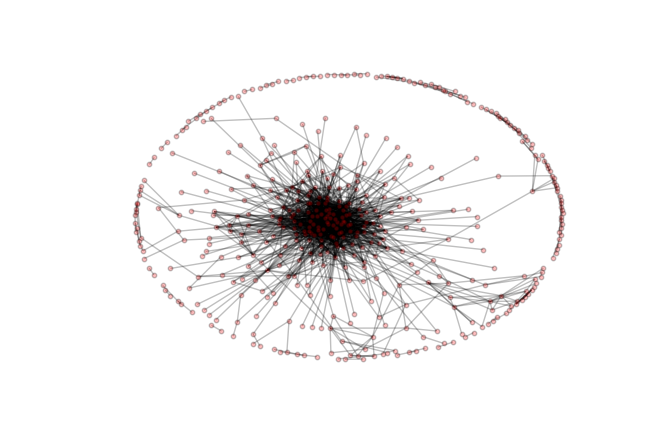

In [23]:
nx.draw(g, node_size=10, alpha=0.25)

In [24]:
commDict = community.best_partition(g)
#colorDict = {k: min(v+1,11) + int(v>11) for k, v in commDict.items()}
colorNames = colors.cnames.keys()
colorDict = {k: colorNames[v] for k, v  in commDict.items()}

In [25]:
colorNames = colors.cnames

In [26]:
g.graph['overlap']='True'

nx.set_node_attributes(g, 'color', colorDict)
nx.set_node_attributes(g, 'colorscheme', 'svg')
nx.set_node_attributes(g, 'style', 'filled')

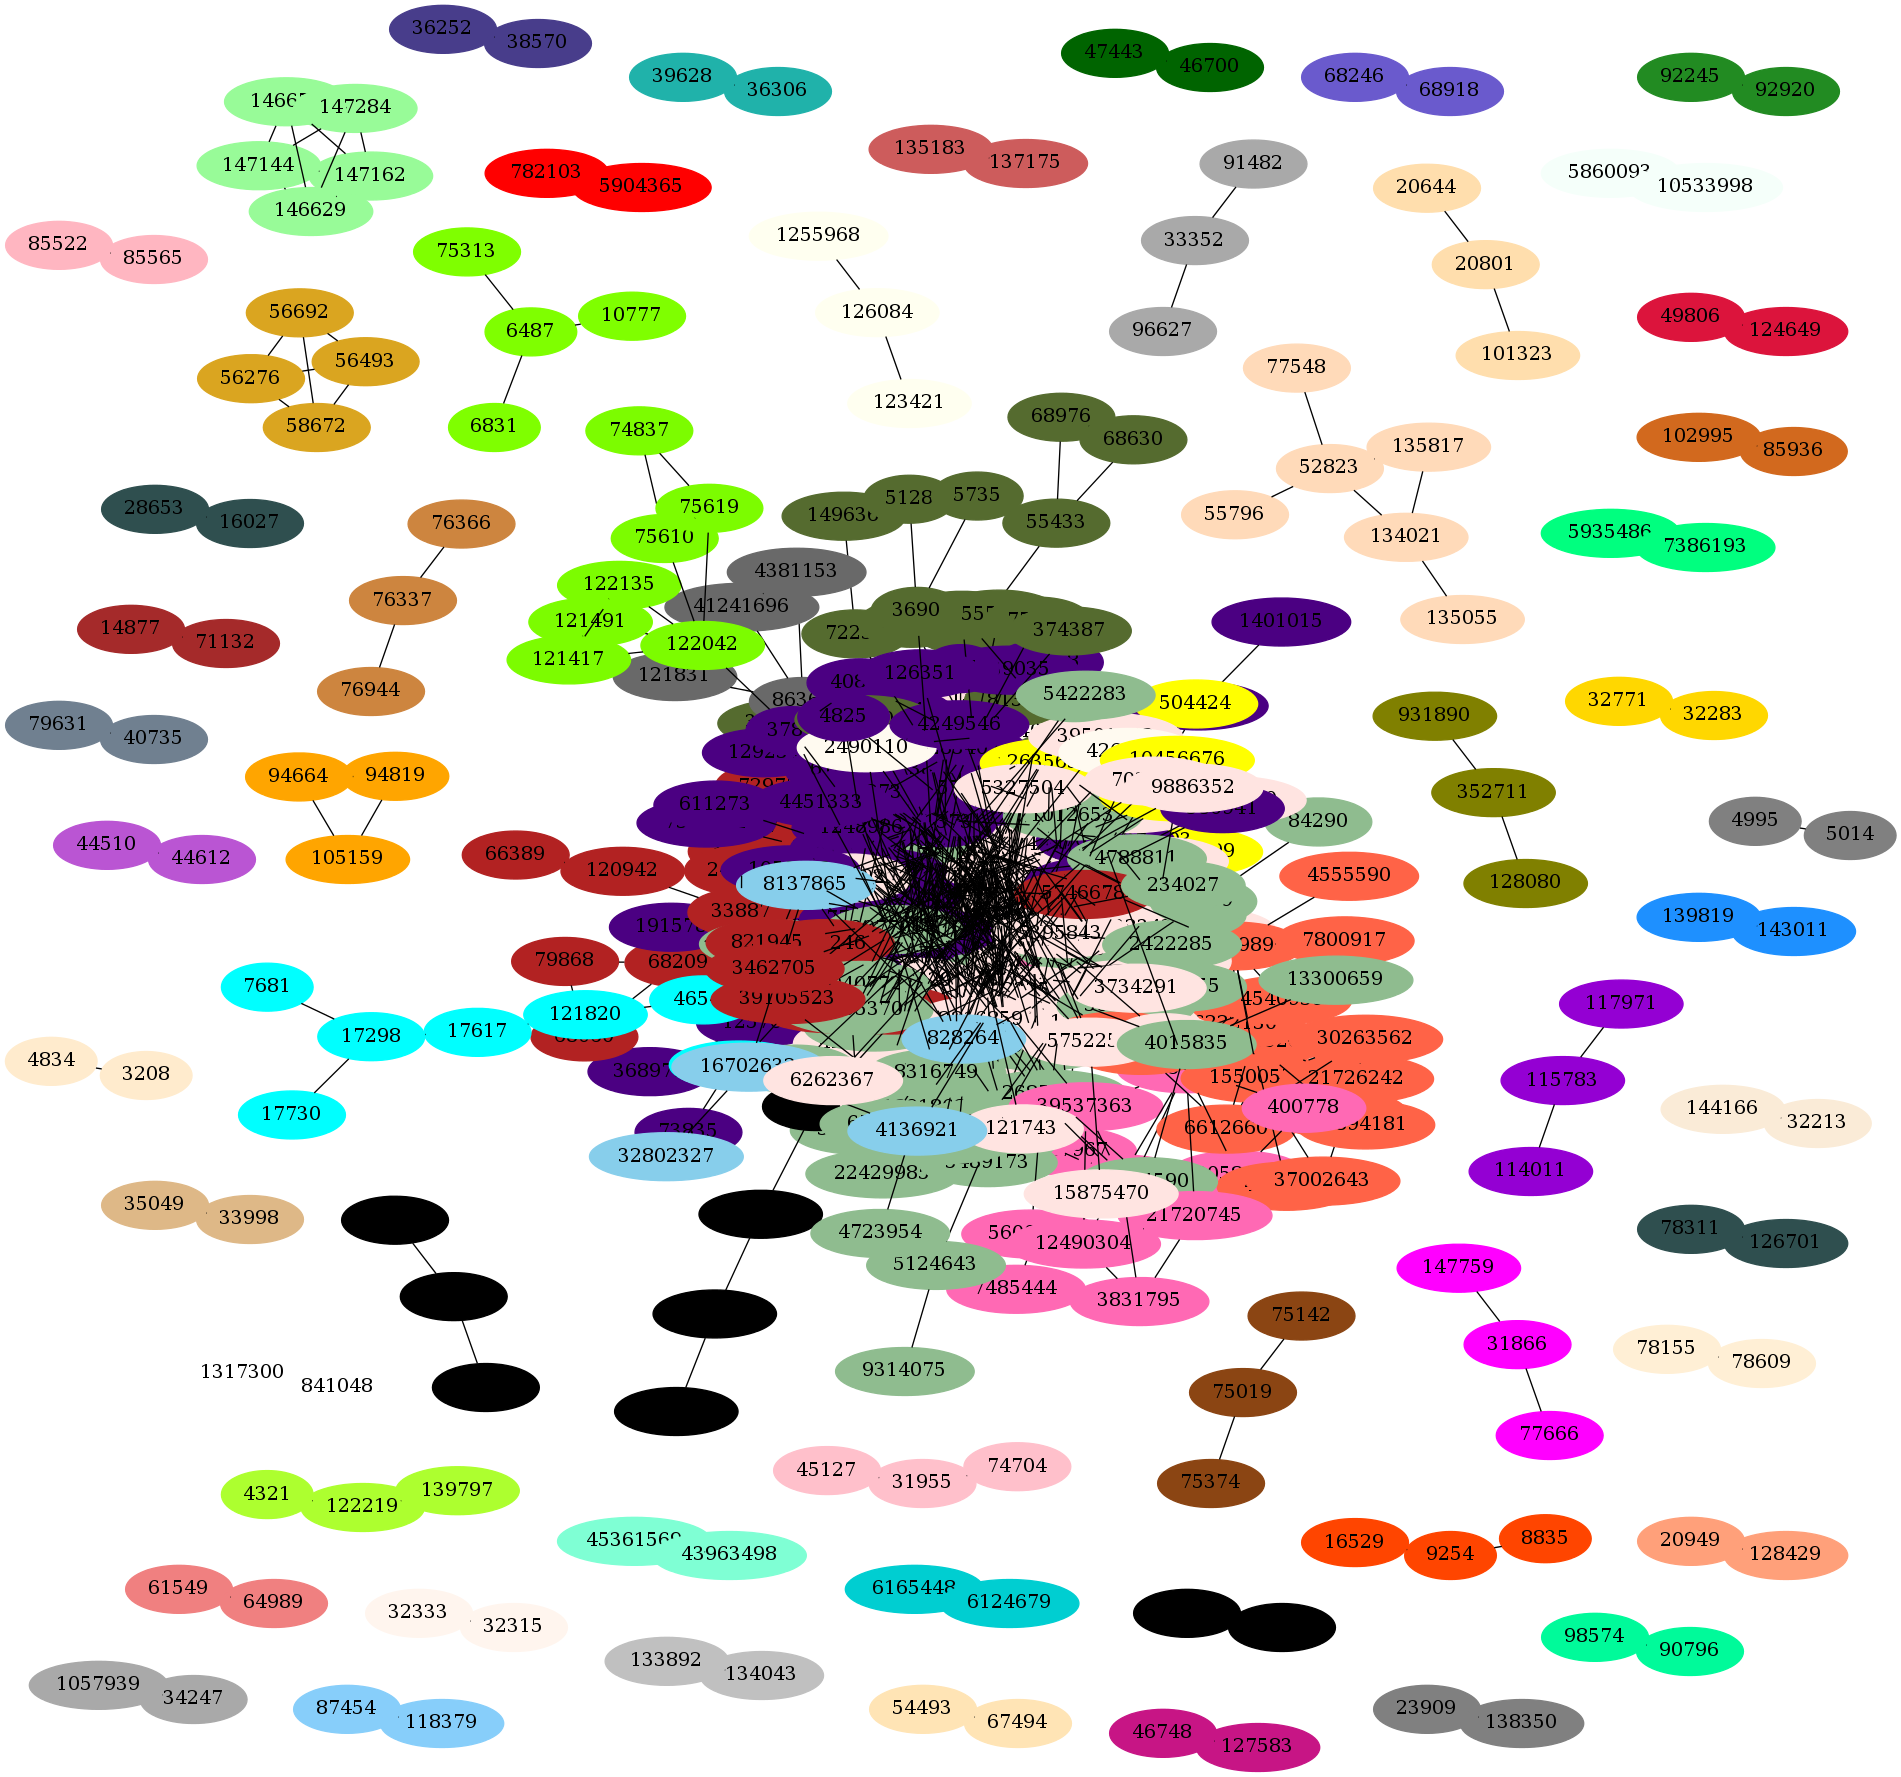

In [27]:
nxpd.draw(g, layout='neato', show='ipynb')

count    471.000000
mean       0.061265
std        0.090894
min        0.000335
25%        0.013333
50%        0.033844
75%        0.076574
max        1.000000
dtype: float64


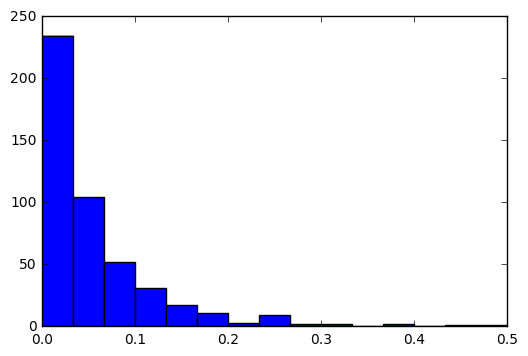

In [28]:
fracFriends = \
pd.Series([float(len(adj_dict[uID])) / len(friends.find_one({'userID': uID})['friends'])\
 for uID in adj_dict.keys()])
print fracFriends.describe()
plt.hist(fracFriends,30);
plt.xlim(0,0.5);

In [29]:
for userID in adj_dict:
    if ratings.find({"userID": userID}).count() == 0:
        ratingDict = getReviews(0.05, userID)
        if ratingDict is not None:
            ratingsToMongo(ratings, userID, ratingDict)
            booksToMongo(books, userID, ratingDict)
    if ratings.count() % 10 == 0:
        print '%d scraped of %d.' % (ratings.count(), len(adj_dict))

In [30]:
collectionAD = dbFromBook['adj_dict']
collectionAD.delete_many({})
collectionAD.insert_one({'adj_dict': {str(k): v for k, v in adj_dict.items()}});

In [31]:
communitySizes = \
[len([uID for uID in commDict if commDict[uID] == i]) for i in range(max(commDict.values()))]

In [234]:
commsOfInterest = [(i, communitySizes[i]) for i in range(len(communitySizes))\
                   if communitySizes[i] > 3 and communitySizes[i] < 30]

In [235]:
communityNodes = \
[[uID for uID in commDict if commDict[uID] == i] for i in range(max(commDict.values()))]

0
{12490304: 0.6666666666666666, 6923777: 0.4, 1754850: 0.26666666666666666, 8788070: 0.3, 29931457: 0.3, 21720745: 0.6666666666666666, 400778: 1.0, 2058064: 0.6666666666666666, 39537363: 0.6666666666666666, 5600393: 1.0, 3831795: 1.0, 31677659: 1.0, 7587967: 0.6666666666666666}

1
{20993440: 1.0, 1713956: 0.23809523809523808, 2658311: 1.0, 79868: 1.0, 2969647: 1.0, 30800: 0.26666666666666666, 68209: 0.3333333333333333, 33747: 1.0, 2309246: 1.0, 31599: 1.0, 68060: 1.0, 5999998: 0.6666666666666666, 33887: 0.3333333333333333}

2
{2300199: 1.0, 83144: 0.6444444444444445, 576203: 0.75, 5745485: 0.7142857142857143, 14431535: 0.9, 25128624: 1.0, 3144945: 0.75, 2493714: 0.8571428571428571, 1733683: 0.6666666666666666, 2635637: 0.8, 350233: 0.9047619047619048}

3
{18213: 0.3333333333333333, 5735: 1.0, 5128: 1.0, 55433: 0.3333333333333333, 3690: 0.3333333333333333, 108654: 0.3333333333333333, 68976: 1.0, 68630: 1.0, 1864633: 1.0}

4
{14591920: 0.3888888888888889, 21726242: 0.6666666666666666, 1

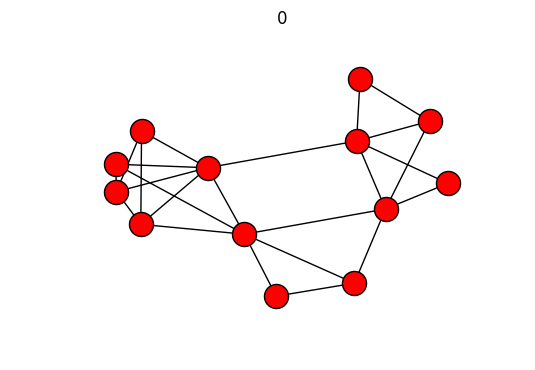

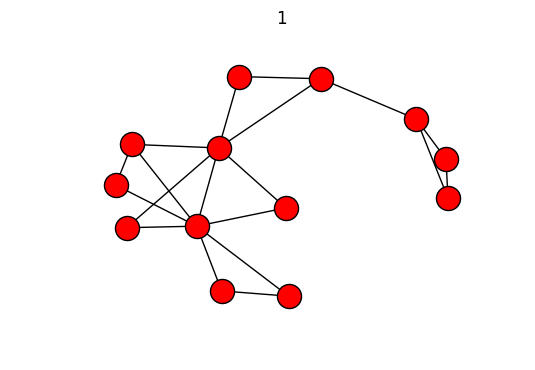

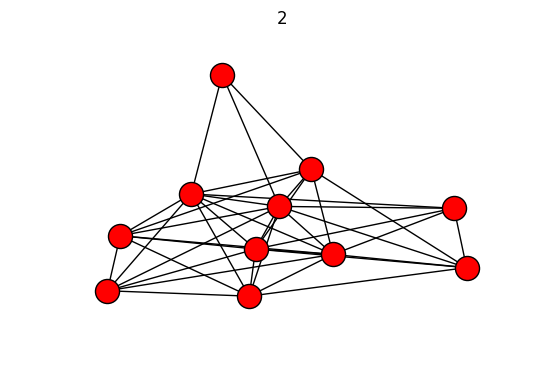

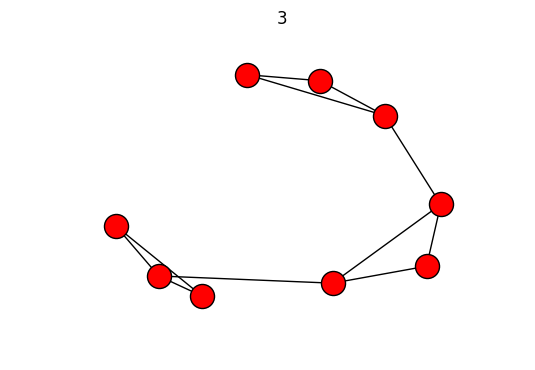

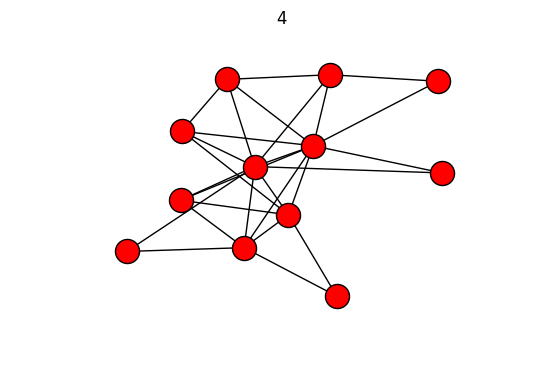

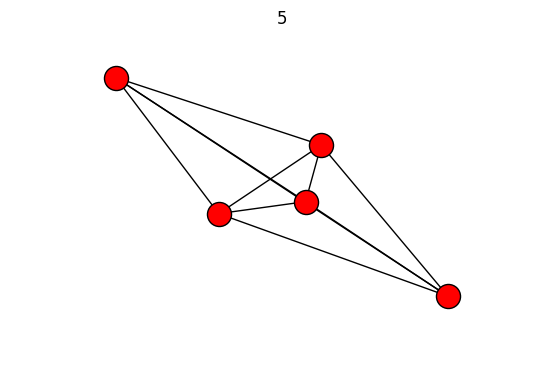

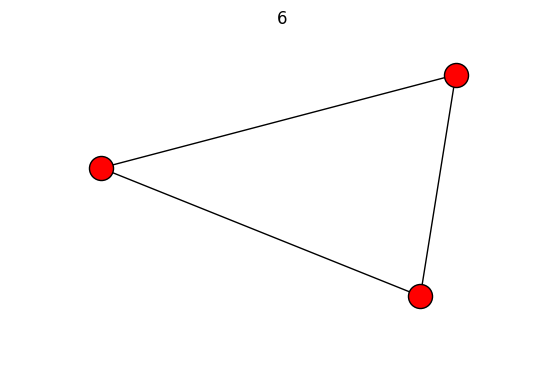

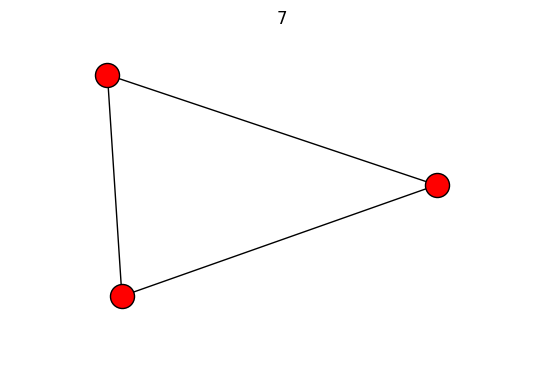

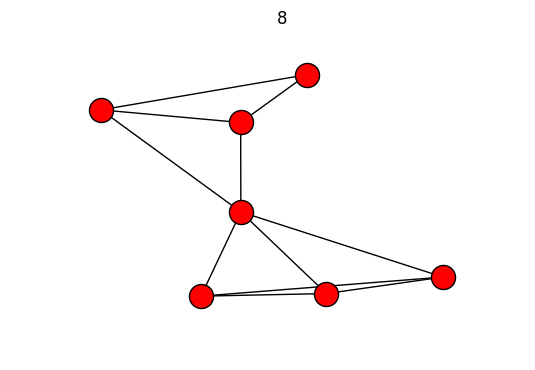

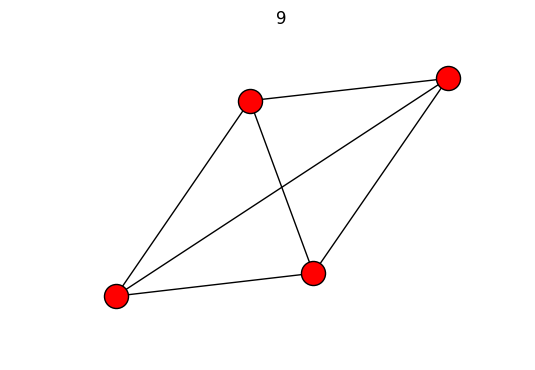

In [236]:
reducedCommsOfInterest = []
for i, commIndex in enumerate(commsOfInterest):
    sg = g.subgraph(communityNodes[commIndex[0]])
    sgClustering = nx.clustering(sg)
    reducedComm = [node for node in communityNodes[commIndex[0]]\
                  if sgClustering[node] > 0]
    if len(reducedComm) > 0 and nx.number_connected_components(sg.subgraph(reducedComm)) == 1:
        reducedCommsOfInterest.append(reducedComm)


for i, comm in enumerate(reducedCommsOfInterest):
    sg = g.subgraph(comm)
    plt.figure()
    print str(i) + '\n' + str(nx.clustering(sg)) + '\n'
    plt.title(i)
    nx.draw(sg, pos=nx.fruchterman_reingold_layout(sg))

In [248]:
'''
for i, commIndex in enumerate(commsOfInterest):
    sg = g.subgraph(communityNodes[commIndex[0]])
    sg.graph['overlap'] = 'scale'
    plt.figure()
    plt.title(str(i) + '\n' + str(nx.average_clustering(sg)))
    nx.draw(sg, labels = nx.clustering(sg), pos=nx.fruchterman_reingold_layout(sg))
'''

"\nfor i, commIndex in enumerate(commsOfInterest):\n    sg = g.subgraph(communityNodes[commIndex[0]])\n    sg.graph['overlap'] = 'scale'\n    plt.figure()\n    plt.title(str(i) + '\n' + str(nx.average_clustering(sg)))\n    nx.draw(sg, labels = nx.clustering(sg), pos=nx.fruchterman_reingold_layout(sg))\n"

In [251]:
dbFromBook['comms'].delete_many({});
dbFromBook['comms'].insert_one({'comms': reducedCommsOfInterest});

In [257]:
dbFromBook.collection_names()

[u'adj_dict',
 u'books',
 u'commBooks',
 u'commFriends',
 u'commRatings',
 u'comms',
 u'friends',
 u'reviews',
 u'system.indexes']

In [253]:
[len(comm) for comm in reducedCommsOfInterest]

[13, 13, 11, 9, 12, 5, 3, 3, 7, 4]

In [254]:
commRatingMeans = []
for commIndex in reducedCommsOfInterest:
    commRatings = []
    for r in ratings.find({'userID': {'$in': commIndex}}):
        if str(focalBookID) in r['ratings']:
            commRatings.append(r['ratings'][str(focalBookID)][0])
    commRatingMeans.append(np.mean(commRatings))

In [276]:
commSets = [set(comm) for comm in reducedCommsOfInterest]

In [286]:

for j, b in enumerate(dbFromBook['commBooks'].find()):
    bookID = b['bookID']
    ratingSet = set([int(k) for k in b['ratings'].keys()])
    commsOfRaters = [i for i, comm in enumerate(commSets)\
                    if len(comm & ratingSet) > 0]
    dbFromBook['commBooks'].update_one(
            {"bookID": bookID},
            {"$set": {'commsOfRaters': commsOfRaters}},
            upsert=True)
    if j % 1000 == 0:
        print float(j) / dbFromBook['commBooks'].count()

0.0
0.0277631250174
0.0555262500347
0.0832893750521
0.111052500069
0.138815625087
0.166578750104
0.194341875121
0.222105000139
0.249868125156
0.277631250174
0.305394375191
0.333157500208
0.360920625226
0.388683750243
0.41644687526
0.444210000278
0.471973125295
0.499736250312
0.52749937533
0.555262500347
0.583025625364
0.610788750382
0.638551875399
0.666315000416
0.694078125434
0.721841250451
0.749604375469
0.777367500486
0.805130625503
0.832893750521
0.860656875538
0.888420000555
0.916183125573
0.94394625059
0.971709375607
0.999472500625
1.02723562564
1.05499875066
1.08276187568
1.11052500069
1.13828812571
1.16605125073
1.19381437575
1.22157750076


In [302]:
books = dbFromBook['commBooks']
ratings = dbFromBook['commRatings']
friends = dbFromBook['commFriends']

commBooks.find_one()

{u'_id': ObjectId('583278a2ae0a79b494b89299'),
 u'bookID': 447,
 u'commsOfRaters': [0, 1],
 u'ratings': {u'2058064': [5, u'not set', u'Feb 21, 2009'],
  u'2969647': [4, u'Sep 15, 2012', u'Sep 13, 2012']}}

In [318]:
booksToExclude = set()
booksToInclude = set()

for b in commBooks.find():
    if len(b['commsOfRaters']) < 2 or len(b['ratings']) < 10:
        booksToExclude.add(b['bookID'])
    else:
        booksToInclude.add(b['bookID'])

In [319]:
print len(booksToExclude)
print len(booksToInclude)
print ratings.count()

35796
223
79


In [320]:
nUserCounts = []
for i, row in enumerate(ratings.find()):
    nUserCounts.append(len(row['ratings']))
    
nBookCounts = []
bookIDlist = []
for i, row in enumerate(books.find({'bookID': {'$in': list(booksToInclude)}})):
    nBookCounts.append(len(row['ratings']))
    bookIDlist.append(row['bookID'])

In [321]:
nUserCounts = pd.Series(nUserCounts)
nBookCounts = pd.Series(nBookCounts)

print nBookCounts.describe()

count    223.000000
mean      14.816143
std        5.039243
min       10.000000
25%       11.000000
50%       13.000000
75%       17.000000
max       39.000000
dtype: float64


In [323]:
glRatingDict = makeRatingDictForGL(ratings, booksToExclude)
glRatings = gl.SFrame(glRatingDict)

In [363]:
for i in range(len(reducedCommsOfInterest)):
    commratings = \
    np.array([row['rating'] for row in glRatings if row['userID'] in reducedCommsOfInterest[i]])
    print (i, len(reducedCommsOfInterest[i]), len(commratings))

(0, 13, 244)
(1, 13, 718)
(2, 11, 923)
(3, 9, 210)
(4, 12, 88)
(5, 5, 316)
(6, 3, 154)
(7, 3, 180)
(8, 7, 248)
(9, 4, 125)
